<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
!pip install torchinfo
from torchinfo import summary
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
import gc
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [2]:
DATA_DIR_BIG = '../input/facesdatasetextended'

In [3]:
image_size = 128
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
def get_dataloader(image_size, batch_size, DATA_DIR):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  data_ds = ImageFolder(DATA_DIR, transform = tt.Compose([
      tt.Resize(image_size),
      tt.ToTensor(),
      tt.Normalize(*stats)
  ]))

  loader = DataLoader(data_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return loader

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
#TODO: build dataloader and transfer it to device
train_dl_big = get_dataloader(image_size, batch_size, DATA_DIR_BIG)

In [8]:
batch = next(iter(train_dl_big))[0]
print(batch.size())

torch.Size([256, 3, 128, 128])


In [9]:
len(train_dl_big.dataset)

70000

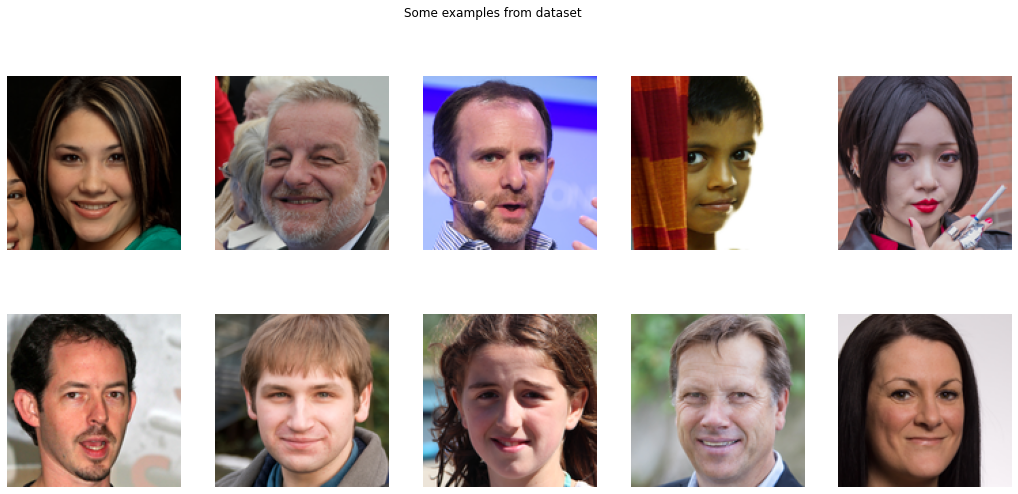

In [10]:
# посмотрим на наши изображения
n_pic = 10

plt.figure(figsize=(18, 8))
for i in range(n_pic):
    plt.subplot(2, n_pic // 2, i + 1)
    plt.imshow(denorm(batch[i]).permute(1, 2, 0))
    plt.axis('off')
plt.suptitle("Some examples from dataset")
plt.show()

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [11]:
class GaussianNoise(nn.Module):
    def __init__(self, gauss_std=0.1, std_decay_rate=0.1):
        super().__init__()
        self.std = gauss_std
        self.decay_rate = std_decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(mean=0, std=self.std)
        else:
            return x

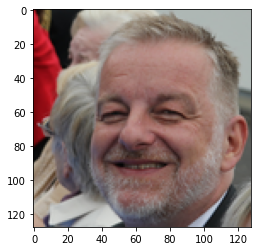

In [12]:

plt.imshow(denorm((batch[1])).permute(1, 2, 0))

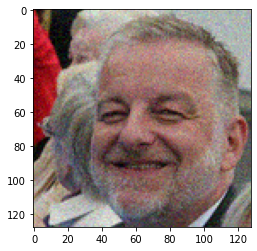

In [13]:
gauss = GaussianNoise()
plt.imshow(denorm(gauss(batch[1])).permute(1, 2, 0))

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    # out: 512 x 16 x 16
    
    nn.Conv2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    # out: 64 x 4 x 4

    nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    )

discriminator_noise = nn.Sequential(
    # in: 3 x 128 x 128
    GaussianNoise(),
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2),
    # out: 64 x 64 x 64

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),
    # out: 128 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    # out: 512 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    # out: 128 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2),
    # out: 64 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    ) 

In [15]:
latent_size = 100

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.Dropout(0.5),
    nn.ReLU(),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    # out: 128 x 32 x 32
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [42]:
def fit(model, criterion, n_epochs, lr_disc, lr_gen, dataloader, label_noise, loss_name):
    # buffer size is a number of batches that can be included in buffer
    # TODO: build optimizers and train your GAN
    gen_losses = []
    disc_losses = []
    real_scores = []
    fake_scores = []

    model["discriminator"].train()
    model["generator"].train()
    gc.collect()
    torch.cuda.empty_cache()

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=lr_disc, 
                                          betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(), lr=lr_gen,
                                      betas=(0.5, 0.999))
    }

    for epoch in tqdm(range(n_epochs)):
        gen_losses_per_epoch = []
        disc_losses_per_epoch = []
        real_scores_per_epoch = []
        fake_scores_per_epoch = []
        
        for ind, real_images in enumerate(tqdm(dataloader)):
            
            real_images = real_images[0].to(device)
            shape = real_images.size()
            
            # Train discriminator
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            if label_noise == True:
                noise = torch.FloatTensor(shape[0], 1).uniform_(0, 0.1).to(device)
            else:
                noise = torch.zeros(shape[0], 1).to(device)
            real_labels = torch.ones(shape[0], 1, device=device) - noise
            fake_labels = torch.zeros(shape[0], 1, device=device) + noise
            
            # Flipping labels with probability 0.1
            if (torch.bernoulli(torch.FloatTensor([0.1]))):
                real_labels, fake_labels = fake_labels, real_labels
            
            real_loss = criterion["discriminator"](real_preds, real_labels)
            cur_real_score = torch.mean(real_preds).item()
                
            # Generate images
            latent = torch.randn(shape[0], latent_size, 1, 1, device=device)
            fake_images1 = model["generator"](latent)
            
            # Pass fake images through discriminator
            
            fake_preds = model["discriminator"](fake_images1.to(device))
            fake_loss = criterion["discriminator"](fake_preds, fake_labels)
            cur_fake_score = torch.mean(fake_preds).item()
            
            real_scores_per_epoch.append(cur_real_score)
            fake_scores_per_epoch.append(cur_fake_score)
            
            # Update discriminator loss
            disc_loss = real_loss + fake_loss
            disc_loss.backward(retain_graph=True)
            optimizer["discriminator"].step()
            disc_losses_per_epoch.append(disc_loss.item())
        
            # Train generator
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(shape[0], latent_size, 1, 1, device=device)
            fake_images2 = model["generator"](latent)

            # Try to fool discriminator
            preds = model["discriminator"](fake_images2.to(device))
            labels = torch.ones(shape[0], 1, device=device)
            gen_loss = criterion["generator"](preds, labels)

            # Update generators weights
            gen_loss.backward()
            optimizer["generator"].step()
            gen_losses_per_epoch.append(gen_loss.item())
            
            # Clear memory
            del fake_images1
            del real_images
            torch.cuda.empty_cache
            
        #Record losses and scores
        gen_losses.append(np.mean(gen_losses_per_epoch))
        disc_losses.append(np.mean(disc_losses_per_epoch))
        real_scores.append(np.mean(real_scores_per_epoch))
        fake_scores.append(np.mean(fake_scores_per_epoch))

        # show intermediate results
        clear_output(wait=True)
        fig = plt.figure(figsize=(24, 8))
        for i in range(6):
            ax = fig.add_subplot(2, 6, i + 1)
            ax.imshow(denorm(fake_images2[i]).permute(1, 2, 0).detach().cpu().numpy())
            ax.set_title("Fake image")
            ax.axis('off')
        del fake_images2
        torch.cuda.empty_cache()
        
        #draw losses and scores
        epochs = np.arange(1, epoch + 2)

        ax1 = fig.add_subplot(2, 2, 3)
        ax1.plot(epochs, gen_losses, label='generator')
        ax1.plot(epochs, disc_losses, label='discriminator')
        ax1.set_title(loss_name + "loss")
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        ax1.grid()
        ax1.legend(fontsize=14)

        ax2 = fig.add_subplot(2, 2, 4)
        ax2.plot(epochs, real_scores, label='real')
        ax2.plot(epochs, fake_scores, label='fake')
        ax2.set_title("Scores")
        ax2.set_xlabel('epochs')
        ax2.set_ylabel('score')
        ax2.grid()
        ax2.legend(fontsize=14)

        plt.suptitle(f"{epoch+1} / {n_epochs} - generator_loss: {gen_losses[-1]:0.4f}, discriminator:{disc_losses[-1]:0.4f}")
        plt.show()

    return gen_losses, disc_losses, real_scores, fake_scores

In [18]:
criterion_bce = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

criterion_mse = {
    "discriminator": nn.MSELoss(),
    "generator": nn.MSELoss()
}

### Default + BCE loss

In [19]:
model = {
    "discriminator": discriminator_noise.to(device),
    "generator": generator.to(device)
}
model['discriminator'].load_state_dict(torch.load('../input/gan-saves/discriminator.pth'))
model['generator'].load_state_dict(torch.load('../input/gan-saves/generator.pth'))   

<All keys matched successfully>

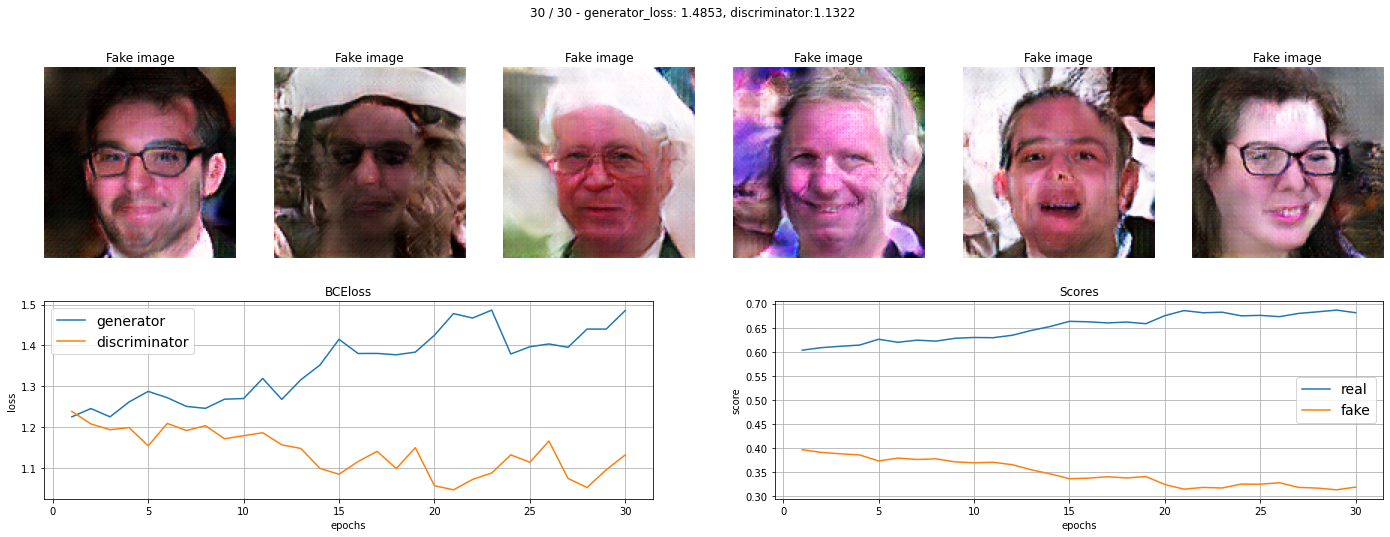

CPU times: user 1h 20min 52s, sys: 3min 44s, total: 1h 24min 37s
Wall time: 1h 31min 1s


In [43]:
%%time

model = {
    "discriminator": discriminator_noise.to(device),
    "generator": generator.to(device)
}
epochs = 30
lr_disc = 0.0002
lr_gen = 0.0004

gen_losses_extended, disc_losses_extended, real_scores_extended, fake_scores_extended = fit(model, criterion_bce, epochs, 
                                                                                        lr_disc, lr_gen, train_dl_big,
                                                                                        True, 'BCE')

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [20]:
n_images = 100
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [21]:
# TODO: show generated images
def show_images(images, nmax=64, figsize=(18, 18)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=int(np.sqrt(nmax))).permute(1, 2, 0))

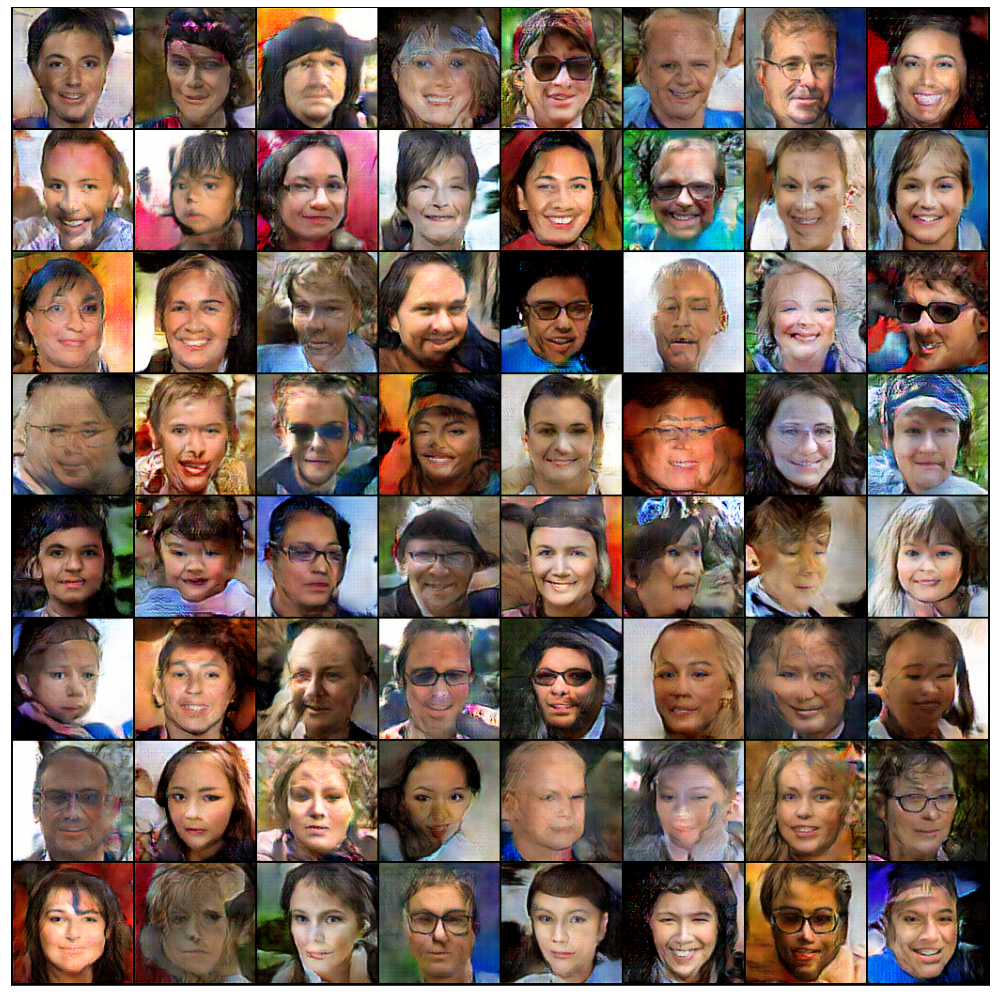

In [22]:
show_images(fake_images)

### higher learning rate

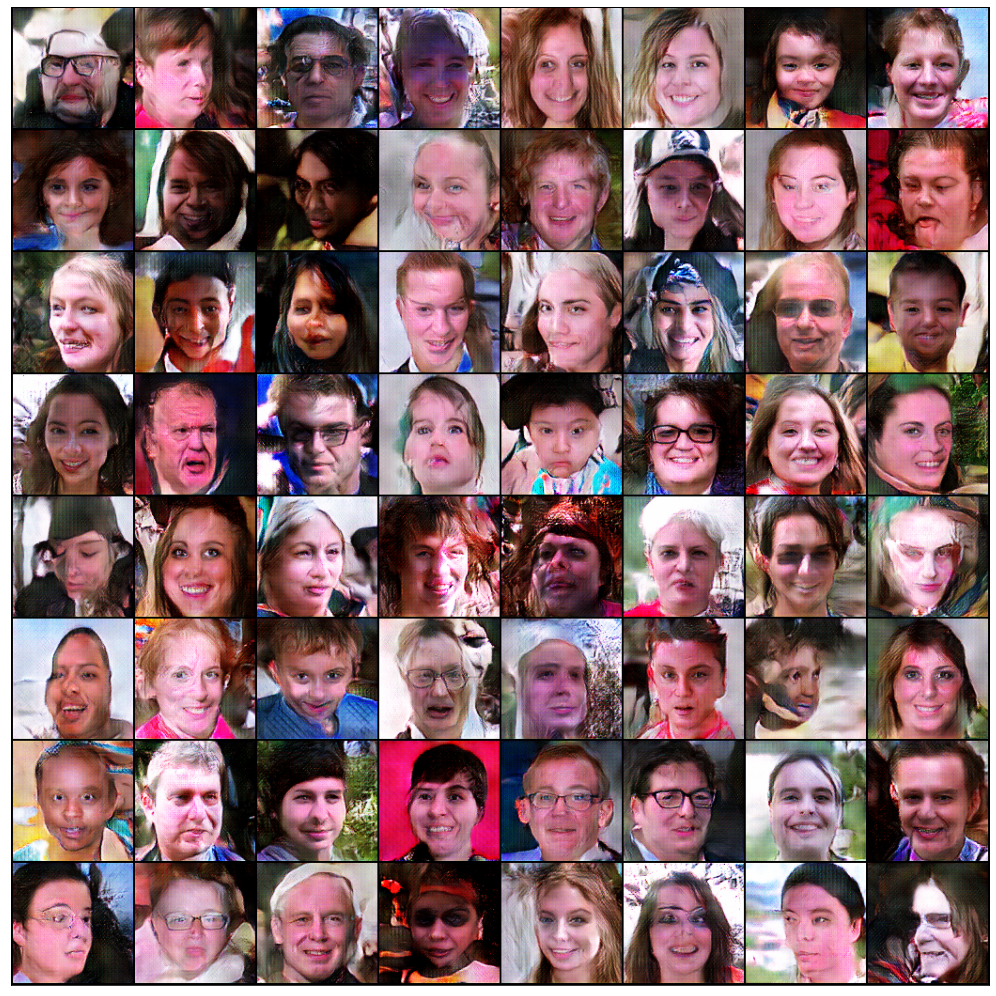

In [49]:
n_images = 100
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

show_images(fake_images)

In [ ]:
torch.save(model['generator'].state_dict())

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [38]:
eff = models.efficientnet_b1(pretrained=True).features[:5].to(device)
summary(eff, input_size=(batch_size, 3, 128, 128))

Layer (type:depth-idx)                             Output Shape              Param #
Sequential                                         [256, 80, 8, 8]           --
├─ConvNormActivation: 1-1                          [256, 32, 64, 64]         --
│    └─Conv2d: 2-1                                 [256, 32, 64, 64]         864
│    └─BatchNorm2d: 2-2                            [256, 32, 64, 64]         64
│    └─SiLU: 2-3                                   [256, 32, 64, 64]         --
├─Sequential: 1-2                                  [256, 16, 64, 64]         --
│    └─MBConv: 2-4                                 [256, 16, 64, 64]         --
│    │    └─Sequential: 3-1                        [256, 16, 64, 64]         1,448
│    └─MBConv: 2-5                                 [256, 16, 64, 64]         --
│    │    └─Sequential: 3-2                        [256, 16, 64, 64]         612
│    │    └─StochasticDepth: 3-3                   [256, 16, 64, 64]         --
├─Sequential: 1-3             

In [39]:
def LOO(model, n_batches):
    features_real = np.zeros((n_batches * batch_size, 80 * 8 * 8))
    features_fake = np.zeros((n_batches * batch_size, 80 * 8 * 8))

    for ind, real_images in enumerate(train_dl_big):
        real_images = real_images[0].to(device)
        features_real[ind * batch_size : (ind + 1) * batch_size] = eff(real_images).flatten(start_dim = 1).detach().cpu().numpy()

        fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = model["generator"](fixed_latent)
        features_fake[ind * batch_size : (ind + 1) * batch_size] = eff(fake_images).flatten(start_dim = 1).detach().cpu().numpy()
        
        if ind + 1 == n_batches:
            break
    
    loo = LeaveOneOut()
    KNN = KNeighborsClassifier(n_neighbors=1)

    total_score = 0
    
    # -1 for LeaveOneOut
    fake_labels = torch.zeros(n_batches * batch_size - 1)
    real_labels = torch.ones(n_batches * batch_size)
    y = np.concatenate((real_labels, fake_labels), axis=0)

    for train_index, test_index in tqdm(loo.split(features_fake)):
        X = np.concatenate((features_real, features_fake[train_index]), axis=0)
        KNN.fit(X, y)
        preds =  KNN.predict_proba(features_fake[test_index])
        total_score += preds[0][0]

    return total_score / features_fake.shape[0]
    

#### Version 1

In [40]:
%%time
LOO(model, n_batches=5)

0it [00:00, ?it/s]

CPU times: user 3min 14s, sys: 2min 18s, total: 5min 33s
Wall time: 3min 6s


0.83359375

**Что вы можете сказать о получившемся результате?** Какой accuracy мы хотели бы получить и почему? Хотели бы получить вероятность 0,5, чтобы признаки наших картинок не отличались, однако в моей оценке отклонение от 0,5 велико, что может говорить как и о несовершенности модели, так и о надобности подбора параметров как:
1. модель классификатора
2. количества его слоев
3. количество данных на обучение

#### Version 2 high generator lr

In [46]:
LOO(model, n_batches=10)

0it [00:00, ?it/s]

0.785546875

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [28]:
def calculate_distribution(model):
    batch = next(iter(train_dl_big))[0]
    embedded_space_real = TSNE(n_components=2).fit_transform(batch.flatten(start_dim=1).numpy())

    fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = model["generator"](fixed_latent)
    embedded_space_fake = TSNE(n_components=2).fit_transform(fake_images.flatten(start_dim=1).detach().cpu().numpy())

    print(embedded_space_real.shape, embedded_space_fake.shape)
    
    return embedded_space_real, embedded_space_fake

In [29]:
def show_distribution(embedded_space_real, embedded_space_fake):

    plt.figure(figsize=(9, 9))

    plt.scatter(x=embedded_space_real[:, 0], y=embedded_space_real[:, 1], label='Real')
    plt.scatter(x=embedded_space_fake[:, 0], y=embedded_space_fake[:, 1], label='Fake')

    plt.title('Embedded space of images')
    plt.legend()
    plt.show()

#### Version 1

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(256, 2) (256, 2)


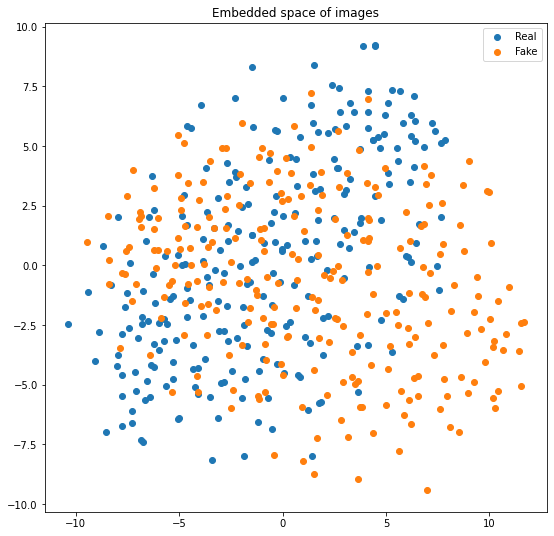

In [30]:
show_distribution(*calculate_distribution(model))

#### Version 2 high generator lr

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(256, 2) (256, 2)


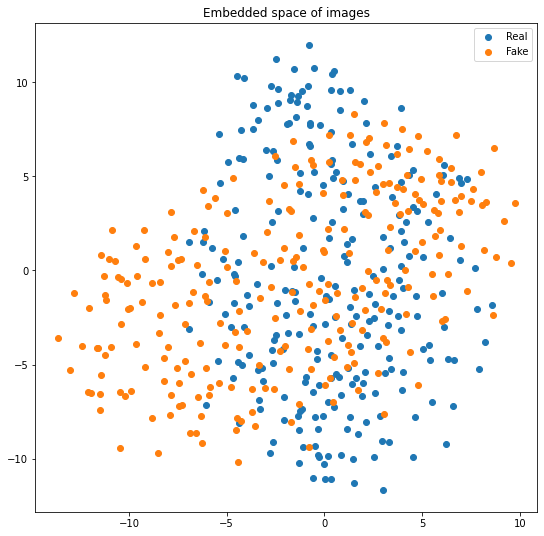

In [50]:
show_distribution(*calculate_distribution(model))

**Прокомментируйте получившийся результат:** на глаз можем оценить, что точки перемешаны достаточно сильно, что говорит о схожем распределении сгенерированных картинок и реальных. Однако есть куда расти, потому что по бокам видно облако точек только фейковых картинок (такие артефакты видны и на визулизации выше)